In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import os
import pandas as pd
import PTA

from IPython.display import display

pd.set_option('display.max_columns', None)

ipyclient = ipp.Client(cluster_id="PTA")
print(len(ipyclient))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
45


In [34]:
!rm analysis/simulations/Gecko-6pops-ancient-SIMOUT.csv

In [57]:
model = PTA.DemographicModel("Gecko-6pops-ancient")
model.set_param("project_dir", "analysis/simulations")
model.set_param("npops", 6)
model.set_param("nsamps", 8)
# Contemporary Ne from stairway plots
model.set_param("N_e", "2e5-5.5e5")
model.set_param("tau", "8e4-5e5")
model.set_param("epsilon", "0.1")
model.set_param("zeta", 0)
model.set_param("length", "300")
#computationally impractical to simulate 2e4 loci for 20 pops, but this is how you'd do it.
#model.set_param("num_replicates", [nloci_dict[x] for x in expanding_pops])
model.set_param("num_replicates", 1000)
model.set_param("recoms_per_gen", 0)
# Mut rate from manuscript, following Harrington et al 2018
model.set_param("muts_per_gen", 2.2e-9)
print(model.get_params())

model._hackersonly["sorted_sfs"] = True
model._hackersonly["proportional_msfs"] = True
model._hackersonly["tau_buffer"] = 100000
model._hackersonly["Ne_loguniform"] = False
model.simulate(nsims=500000, quiet=False, verbose=False, ipyclient=ipyclient)

------- PTA params - DemographicModel - (v.0.0.11) -----------------------------
Gecko-6pops-ancient  ## [0] [simulation_name]: The name of this simulation scenario
/home/isaac/proj/Islands2030/PTA-GalapagosGeckos/analysis/simulations ## [1] [project_dir]: Where to save files
6                    ## [2] [npops]: Number of populations undergoing co-demographic processes
8                    ## [3] [nsamps]: Numbers of samples for each populations
200000-550000        ## [4] [N_e]: Effective population size of the contemporary population
80000-500000         ## [5] [tau]: Time of demographic change
0.1                  ## [6] [epsilon]: Magnitude of demographic change
0.0                  ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
300                  ## [8] [length]: Length in bp of each independent genomic region to simulate
1000,1000,1000,1000,1000,1000 ## [9] [num_replicates]: Number of genomic regions to simulate
1                    ## [10] [generat

In [2]:
# The 'reference table'
sorted_sim_df = pd.read_csv("analysis/simulations/Gecko-6pops-ancient-SIMOUT.csv", sep=" ")

# Drop zeta_e == 0 (meaningless)
sorted_sim_df = sorted_sim_df[sorted_sim_df.zeta_e > 0]
print(len(sorted_sim_df))
# This is a input
synthetic_community = pd.DataFrame(sorted_sim_df.loc[0]).T.drop(PTA.inference.default_targets, axis=1)

## RF parameters from a cv_search process which took like a day, don't want to redo it.
rf_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'max_depth': 70,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
rf_sorted_cl = PTA.inference.Classifier(empirical_df=synthetic_community,
                                       sims=sorted_sim_df,
                                       algorithm="rf")
# Set GB model params
rf_sorted_cl.set_params(rf_params)
# Set the target for classification
rf_sorted_cl.set_targets(["zeta_e"])
# Run quickly to set up the model
rf_sorted_cl.predict(select_features=False, param_search=False, quick=True, verbose=True)
# Do the cross validation prediction
cv_preds = rf_sorted_cl.cross_val_predict(cv=3,
                    quick=True,
                    verbose=True)

600000
Predict() started: 2023-12-14 11:04:23.113921
Predict() finished: 2023-12-14 11:07:32.799297


/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1050: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1050: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/isaac

              precision    recall  f1-score   support

           1       0.32      0.54      0.40     99891
           2       0.25      0.15      0.19     99666
           3       0.24      0.15      0.18    100226
           4       0.27      0.21      0.24    100299
           5       0.35      0.25      0.29     99769
           6       0.47      0.78      0.59    100149

    accuracy                           0.35    600000
   macro avg       0.32      0.35      0.32    600000
weighted avg       0.32      0.35      0.32    600000



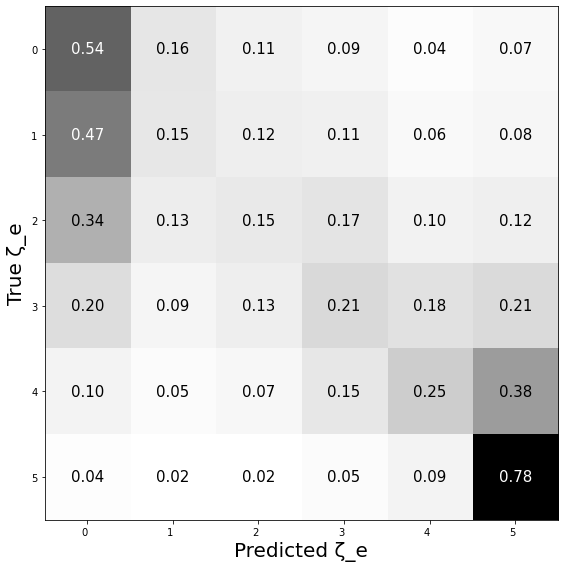

In [5]:
ax = rf_sorted_cl.plot_confusion_matrix(normalize=True)

,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]],pop3-[[7_1]],pop3-[[6_2]],pop3-[[5_3]],pop3-[[4_4]],pop4-[[7_1]],pop4-[[6_2]],pop4-[[5_3]],pop4-[[4_4]],pop5-[[7_1]],pop5-[[6_2]],pop5-[[5_3]],pop5-[[4_4]]
0,0.748994,0.227795,0.129205,0.058646,0.669777,0.219819,0.114924,0.048039,0.65411,0.219751,0.11353,0.047568,0.617756,0.194032,0.108528,0.047225,0.610637,0.190137,0.096651,0.03954,0.592331,0.157883,0.067235,0.025889


Predict() started: 2023-12-14 14:51:17.599617


,1,2,3,4,5,6
zeta_e,0.184821,0.218339,0.24522,0.188031,0.102281,0.061308


CPU times: user 527 ms, sys: 105 ms, total: 632 ms
Wall time: 537 ms


<BarContainer object of 6 artists>

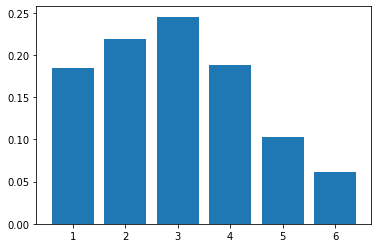

In [49]:
%%time
# Load msfs and reshape it into a format the ML stuff expects
sorted_expanding_msfs = pd.read_csv("/home/isaac/proj/Islands2030/PTA-GalapagosGeckos/analysis/msfs/ancient-proj8-sort-props.msfs", index_col=0)
sorted_expanding_msfs = pd.DataFrame(sorted_expanding_msfs.to_numpy().ravel(order="F"), index=synthetic_community.columns).T
display(sorted_expanding_msfs)

rf_sorted_cl.set_data(sorted_expanding_msfs)
rf_class_est = rf_sorted_cl.predict(select_features=False,\
                                    param_search=False,\
                                    quick=True,\
                                    verbose=True)
#axs = gb_sorted_cl.plot_feature_importance()
display(rf_class_est[1])
plt.bar(range(1, 7), rf_class_est[1].values[0])

Removed invariant targets. Retained: ['t_s', 'omega', 'taus_mean']
Predict() started: 2023-12-14 11:44:25.685684
Predict() finished: 2023-12-14 11:55:03.101034


/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/isaac/miniconda3/envs/PTA/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

                     MAE        RMSE    vscore        R2
t_s        124421.170281  276.016407  0.564163  0.564156
taus_mean   61400.874195  139.153328  0.726834  0.726831
taus_std    22811.926450   51.547656  0.262308  0.262303
CPU times: user 4h 9min 26s, sys: 3min 2s, total: 4h 12min 29s
Wall time: 54min 38s


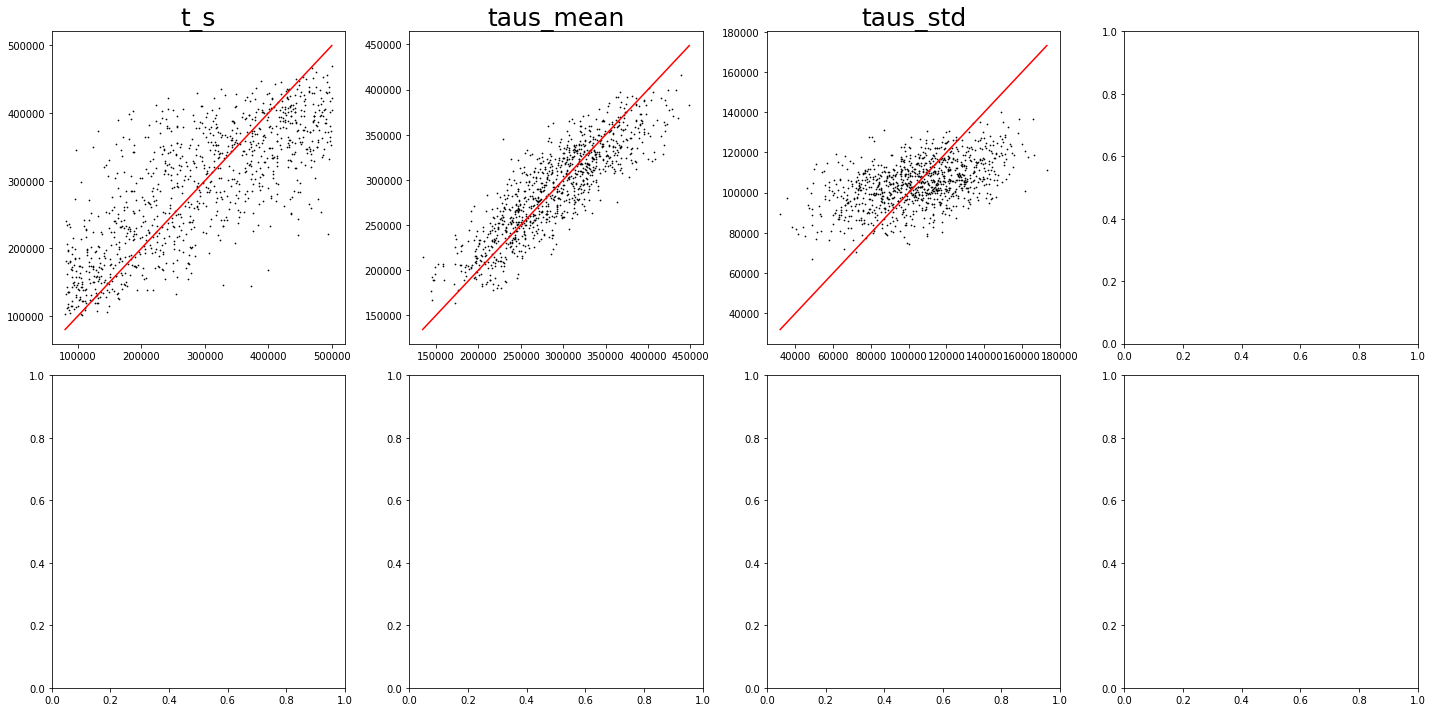

In [8]:
%%time
pruned_sorted_df = sorted_sim_df[sorted_sim_df["zeta_e"].between(2, 4)]

rf_rgr = PTA.inference.Regressor(empirical_df=synthetic_community,\
                                sims=pruned_sorted_df,\
                                algorithm="rf",\
                                verbose=True)
rf_rgr.set_params(rf_params)
rf_rgr.set_targets(["t_s", "taus_mean", "taus_std"])
rf_rgr.predict(select_features=False,\
            param_search=False,\
            quick=False,\
            verbose=True)
rg_rgr_preds = rf_rgr.cross_val_predict(verbose=True)
ax = rf_rgr.plot_cv_predictions(figsize=(20,10), figdims=(2,4))

In [9]:
rf_param_est = rf_rgr.predict(sorted_expanding_msfs)
rf_param_est

,t_s,taus_mean,taus_std
estimate,182266.469554,241221.381067,108829.682757


In [40]:
import numpy as np
def pred_ints(model, X, percentile=95):
    preds = []
    err_down = []
    err_up = []
    for pred in model.best_model.estimators_:
        preds.append(pred.predict(X))
    err_down = np.percentile(preds, (100 - percentile) / 2. , axis=0)[0]
    err_up = np.percentile(preds, 100 - (100 - percentile) / 2., axis=0)[0]
    return err_down, err_up

err_down, err_up = pred_ints(rf_rgr, sorted_expanding_msfs, percentile=50)
pred_intervals = pd.DataFrame(np.array([err_down, rf_param_est.values[0], err_up]), columns=rf_param_est.columns)
pred_intervals

,t_s,taus_mean,taus_std
0,115585.416667,204086.038877,91131.284554
1,182266.469554,241221.381067,108829.682757
2,198569.642857,235284.027667,119827.810750


(array([144., 187., 161., 149., 151., 105.,  98.,  66.,  66.,  48.,  58.,
         38.,  47.,  23.,  23.,  15.,  10.,   6.,   2.,   3.]),
 array([ 84575.        ,  99120.48076923, 113665.96153846, 128211.44230769,
        142756.92307692, 157302.40384615, 171847.88461538, 186393.36538462,
        200938.84615385, 215484.32692308, 230029.80769231, 244575.28846154,
        259120.76923077, 273666.25      , 288211.73076923, 302757.21153846,
        317302.69230769, 331848.17307692, 346393.65384615, 360939.13461538,
        375484.61538462]),
 <BarContainer object of 20 artists>)

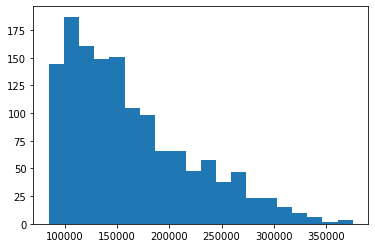

In [43]:
def pred_ints(model, X):
    preds = []
    err_down = []
    err_up = []
    p = np.linspace(0, 100, 10)
    for pred in model.best_model.estimators_:
        preds.append(pred.predict(X))
    percentiles = np.percentile(preds, p, axis=0)[0]
    return preds
_preds = pred_ints(rf_rgr, sorted_expanding_msfs)
#plt.plot(np.percentile(_preds, np.linspace(0, 100, 10), axis=0)[:, :, 0])
plt.hist(np.array(_preds)[:, :, 0], bins=20)


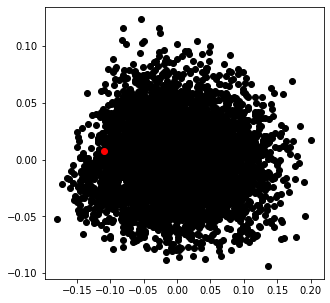

In [44]:
from sklearn.decomposition import PCA

estimated_zeta = 3

dat = sorted_sim_df[sorted_sim_df["zeta_e"] == estimated_zeta].iloc[-5000:, 23:]
dat = pd.concat([sorted_expanding_msfs, dat])

pca = PCA(n_components=2)
pcs = pca.fit_transform(dat)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(pcs[:, 0], pcs[:, 1], c='black')
## Plot the observed ss in red
ax.scatter(pcs[:, 0][0], pcs[:, 1][0], c='r')

## Trash

In [32]:
sorted_sim_df

,zeta,zeta_e,psi,t_s,omega,taus_mean,taus_std,taus_skewness,taus_kurtosis,taus_median,taus_iqr,epsilons_mean,epsilons_std,epsilons_skewness,epsilons_kurtosis,epsilons_median,epsilons_iqr,Ne_s_mean,Ne_s_std,Ne_s_skewness,Ne_s_kurtosis,Ne_s_median,Ne_s_iqr,pop0-[[7_1]],pop0-[[6_2]],pop0-[[5_3]],pop0-[[4_4]],pop1-[[7_1]],pop1-[[6_2]],pop1-[[5_3]],pop1-[[4_4]],pop2-[[7_1]],pop2-[[6_2]],pop2-[[5_3]],pop2-[[4_4]],pop3-[[7_1]],pop3-[[6_2]],pop3-[[5_3]],pop3-[[4_4]],pop4-[[7_1]],pop4-[[6_2]],pop4-[[5_3]],pop4-[[4_4]],pop5-[[7_1]],pop5-[[6_2]],pop5-[[5_3]],pop5-[[4_4]]
0,0.204,2,1,483700.0,71970.900,305500.000,148280.511,-0.049,-1.491,305700.0,264975.0,0.1,0.0,0.0,-3.0,0.1,0.0,61653.833,32395.926,-0.267,-1.319,65328.0,51778.00,0.567,0.377,0.250,0.123,0.521,0.300,0.193,0.110,0.500,0.283,0.179,0.095,0.444,0.268,0.175,0.071,0.396,0.204,0.169,0.064,0.321,0.201,0.166,0.025
1,0.656,4,1,273800.0,10887.156,262916.667,53501.539,-1.136,0.445,273800.0,0.0,0.1,0.0,0.0,-3.0,0.1,0.0,61581.167,18708.126,0.575,-0.714,57243.5,20560.75,0.503,0.300,0.229,0.121,0.500,0.294,0.185,0.104,0.488,0.268,0.177,0.088,0.469,0.265,0.175,0.083,0.442,0.223,0.155,0.077,0.429,0.221,0.135,0.067
2,0.486,3,1,95600.0,87439.530,188800.000,128485.732,1.209,-0.036,122100.0,127625.0,0.1,0.0,0.0,-3.0,0.1,0.0,59853.000,8692.371,-0.197,-1.032,62603.0,9435.25,0.548,0.271,0.240,0.114,0.541,0.271,0.186,0.087,0.527,0.249,0.178,0.081,0.481,0.246,0.162,0.071,0.453,0.220,0.154,0.070,0.429,0.216,0.151,0.056
3,0.253,2,1,279100.0,35580.747,314683.333,105814.309,0.438,-1.220,279100.0,137175.0,0.1,0.0,0.0,-3.0,0.1,0.0,54208.000,26670.108,-0.291,-1.591,60354.5,48881.50,0.530,0.312,0.251,0.114,0.500,0.299,0.244,0.101,0.442,0.283,0.213,0.083,0.414,0.259,0.208,0.078,0.403,0.231,0.150,0.072,0.388,0.221,0.139,0.067
4,0.512,4,1,297200.0,28412.612,240616.667,82683.421,-0.901,-0.960,297200.0,100275.0,0.1,0.0,0.0,-3.0,0.1,0.0,59895.667,22105.952,0.506,-1.386,52534.0,35874.50,0.536,0.277,0.220,0.123,0.480,0.269,0.200,0.113,0.476,0.267,0.195,0.103,0.462,0.258,0.194,0.088,0.452,0.247,0.169,0.062,0.445,0.202,0.103,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49991,0.699,5,1,146100.0,22663.892,174200.000,62833.510,1.789,1.200,146100.0,0.0,0.1,0.0,0.0,-3.0,0.1,0.0,60343.167,26519.636,0.087,-1.455,58302.0,44223.25,0.543,0.312,0.272,0.134,0.481,0.301,0.224,0.113,0.450,0.283,0.221,0.087,0.435,0.271,0.173,0.087,0.414,0.219,0.151,0.071,0.380,0.195,0.119,0.065
49992,0.614,4,1,221100.0,34235.596,278466.667,97639.501,1.497,0.568,221100.0,58500.0,0.1,0.0,0.0,-3.0,0.1,0.0,52257.667,17115.562,-0.586,-1.358,59521.0,28002.25,0.497,0.262,0.250,0.117,0.493,0.255,0.207,0.101,0.458,0.252,0.205,0.099,0.451,0.249,0.202,0.094,0.448,0.225,0.184,0.082,0.436,0.219,0.147,0.067
49993,0.195,2,1,131100.0,75212.411,236533.333,133380.067,0.610,-0.963,200750.0,175825.0,0.1,0.0,0.0,-3.0,0.1,0.0,62321.500,28712.016,-0.392,-1.457,70064.0,48535.50,0.567,0.325,0.188,0.111,0.524,0.318,0.186,0.087,0.506,0.312,0.178,0.083,0.465,0.246,0.169,0.067,0.446,0.234,0.156,0.055,0.400,0.201,0.150,0.026
49994,0.052,1,0,117400.0,58566.307,312583.333,135302.814,-0.316,-1.518,345350.0,233425.0,0.1,0.0,0.0,-3.0,0.1,0.0,35813.833,25657.760,0.408,-1.356,25905.5,35654.50,0.476,0.400,0.259,0.108,0.464,0.356,0.232,0.098,0.439,0.259,0.208,0.085,0.414,0.250,0.208,0.077,0.400,0.244,0.207,0.069,0.328,0.220,0.200,0.000
